In [279]:
import requests
import nyc_geoclient
from nyc_geoclient import Geoclient
import numpy as np
import pandas as pd
import geopandas as gpd
import folium as fl
import mplleaflet as mpll
import seaborn as sns
import pylab as plt
from IPython.display import HTML
from datetime import datetime
% pylab inline

from geopandas import GeoSeries, GeoDataFrame
from shapely.geometry import Point

from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation
from sklearn.model_selection import train_test_split

import sodapy
from sodapy import Socrata

Populating the interactive namespace from numpy and matplotlib


In [10]:
path = "/projects/18_predicting_igc/shared/data/"

# I registered this ID and key to the GeoCoder API for our project, so use it if you wish

app_ID = "ebc3a911"
app_key = "4bf9b57657e7fedb10b6998182f588e6"
g = Geoclient(app_ID, app_key)

## 1. Import and clean master inspections csv
This is Kelsey's latest version and includes census data plus PLUTO for each unique complaint ID


In [208]:
df = pd.read_csv("inspections_master_v5.csv")
columns = [col for col in df.columns]

In [209]:
df.drop(columns=['fire_violations','ECB_violation_number'],inplace=True)
df['insp_date']=pd.to_datetime(df['insp_date'])
df.head(2)

,Unnamed: 0,Unnamed: 0.1,priority_code,community_board,address,ZIP,borough,BIN,ID,complaint_category,...,Norm_Tot_S,Norm_Tot_A,Norm_Tot_B,Norm_Tot_M,Norm_Tot_P,Norm_Med_H,Norm_Tot_O,Norm_Tot_V,Norm_Tot_1,Norm_Tot_R
0,0,0,B,102,110 CHRISTOPHER STREET,10014.0,Manhattan,1010038,1272891,66,...,0.097589,0.042671,0.477421,0.202641,0.0,28.682185,0.82,0.18,0.25,3.04
1,1,2,C,110,2492 7 AVENUE,10030.0,Manhattan,1060459,1272972,94,...,0.201787,0.054574,0.090503,0.029715,0.0,8.422677,0.91,0.09,0.02,43.64


## 2. Query 311 complaints through Socrata
This function pulls out counts of 311 complaints in a radius around a building for
a given time window.

In [ ]:
client = Socrata("data.cityofnewyork.us", "uLp3qFGblbiC7tI4pcHRU41fd")
nyc_dataset_identifier = 'fhrw-4uyv'

center = "40.729526, -73.993844"

In [543]:
def count_311_complaints(ID,radius=500,daysback=365,agency="DSNY"):
    
    """Returns counts of selected 311 complaints within a given radius
    of the complaint ID in a given time window.
    """
    
    end_date = df.insp_date[df.ID == ID].iloc[0]
    start_date = end_date - datetime.timedelta(days = daysback)
    
    date_term = "created_date between '" + \
    str(start_date.isoformat()) + "' and '" + str(end_date.isoformat()) +"'"
    
    location_term = "within_circle(location,"+center + ", 500)"
    
    results = client.get(nyc_dataset_identifier,
        select = "count(bbl)",             
        where= "agency = '" + agency + "' and "+ date_term +" and " + location_term)

    return(results)

In [551]:
for daysback in [150,365,1865]:
    for agency in ['DSNY','DOB','NYPD']:
        print("{} complaints in past {} days: ".format(agency, daysback), count_311_complaints(sample_ID,daysback=daysback,agency=agency))

('DSNY complaints in past 150 days: ', [{u'count_bbl': u'207'}])
('DOB complaints in past 150 days: ', [{u'count_bbl': u'103'}])
('NYPD complaints in past 150 days: ', [{u'count_bbl': u'613'}])
('DSNY complaints in past 365 days: ', [{u'count_bbl': u'410'}])
('DOB complaints in past 365 days: ', [{u'count_bbl': u'268'}])
('NYPD complaints in past 365 days: ', [{u'count_bbl': u'1542'}])
('DSNY complaints in past 1865 days: ', [{u'count_bbl': u'1485'}])
('DOB complaints in past 1865 days: ', [{u'count_bbl': u'1341'}])
('NYPD complaints in past 1865 days: ', [{u'count_bbl': u'6380'}])


In [497]:
df.iloc[df.ECB_violations.idxmax()]

Unnamed: 0                                                                      5950
Unnamed: 0.1                                                                   10007
priority_code                                                                      C
community_board                                                                  105
address                                                  105          WEST 34 STREET
ZIP                                                                            10001
borough                                                                    Manhattan
BIN                                                                          1015219
ID                                                                           1471413
complaint_category                                                                94
complaint_category_description             PLUMBING-DEFECTIVE/LEAKING/NOT MAINTAINED
complaint_source                                                 

In [413]:
###### sample_ID = df.ID.iloc[df.ECB_violations.idxmax()]

end_date = df.insp_date[df.ID == sample_ID].iloc[0]
start_date = end_date - datetime.timedelta(days = 360)

### 2.1 Demo of mapping a given query
Complaints about 'adult establishments' (!) in each part of the city

In [76]:
# make lat and lon into numbers
results_df.latitude = pd.to_numeric(results_df.latitude)
results_df.longitude = pd.to_numeric(results_df.longitude)
#results_df.dtypes

In [77]:
s = gpd.GeoSeries([Point(x,y) for x, y in zip(results_df['longitude'], results_df['latitude'])])
geo_df = gpd.GeoDataFrame(results_df,geometry = s)
geo_df.crs = {'init': 'epsg:4326'}

In [78]:
geo_df.head(2)

,address_type,agency,agency_name,bbl,borough,city,closed_date,community_board,complaint_type,created_date,...,park_borough,park_facility_name,resolution_action_updated_date,resolution_description,status,street_name,unique_key,x_coordinate_state_plane,y_coordinate_state_plane,geometry
0,ADDRESS,DOB,Department of Buildings,1000800004,MANHATTAN,NEW YORK,2017-02-03T12:05:39.000,01 MANHATTAN,Special Projects Inspection Team (SPIT),2017-02-03T12:05:39.000,...,MANHATTAN,Unspecified,2017-02-03T00:00:00.000,The Department of Buildings investigated this ...,Closed,CHURCH STREET,35410275,981338,198478,POINT (-74.01050379268059 40.7114525313996)
1,ADDRESS,DOB,Department of Buildings,1008220067,MANHATTAN,NEW YORK,2017-04-27T00:00:00.000,05 MANHATTAN,Special Projects Inspection Team (SPIT),2017-02-08T19:31:09.000,...,MANHATTAN,Unspecified,2017-04-27T00:00:00.000,The Department of Buildings attempted to inves...,Closed,WEST 21 STREET,35447461,986444,209212,POINT (-73.99208258522924 40.74091495786753)


In [564]:
fig, ax = plt.subplots(1, figsize=(10,10))
geo_df.plot(c='r',ax=ax)
mpll.display(fig=fig, crs = geo_df.crs, tiles='cartodb_positron')

## 3. Function to add violation counts
Should be able to use one function for multiple datasets

#### 3.1 Load and clean violation datasets to count from
Get counts from any dataset which has BIN and VIO_DATE

In [261]:
fire_violations = pd.read_csv(path + 'Additional Risk Factors/Bureau_of_Fire_Prevention_-_Active_Violation_Orders.csv')
wwp = pd.read_csv(path + 'work_without_permit_violation_issued_by_plumbing_unit_since_010110.csv')
laa = pd.read_csv(path + 'laa_filings_2010_2017.csv')
complaints_deduped = pd.read_csv(path + 'inspections_master_v1_1.csv')

In [211]:
# Make violation date a datetime object

fire_violations.rename(columns={'VIO_DATE':'DATE'},inplace=True)

fire_violations.DATE=pd.to_datetime(fire_violations.DATE)

In [262]:
### Work Without Permit (WWP) violations
wwp.rename(columns={'Vio Issued Date':'DATE',
                   'BIN-Occurrence':'BIN',
                   'Block-Occurrence':'Block'},inplace=True)

#wwp.drop(axis = 1, columns = ['License# Rep','House# Resp'],inplace=True)
wwp.dropna(axis=0,inplace=True)

wwp.BIN.astype(int,copy=True)
wwp['DATE']=pd.to_datetime(wwp['DATE'])


In [213]:
# 1L referrals dataset prep

referrals_1L = pd.read_csv(path + "gas_high_risk_1l_utility_referral_since_aug_2016.csv")
referrals_1L.rename(columns={'COMPLAINT_DATE':'DATE',
                   'BIN Number':'BIN'},inplace=True)
referrals_1L['DATE']=pd.to_datetime(referrals_1L['DATE'])
referrals_1L.head(1)

,BIN,Complaint Number,Complaint Category,Complaint Category Description,Priority Code,Borough Digit,Borough Name,P_HOUSE_NUMBER,P_STREET_NAME,P_ZIP,...,D_MONTH,D_YEAR,INSPECTION_DATE,Inspector ID,Disposition Code,Complaint Disposition Description,cnxarraycolumn,Inspector Comments,C_NOTIFICATION_TEXT,ECB Violation Number
0,1000040,1467087,1L,GAS UTILITY REFERRAL,D,1,Manhattan,15,STONE STREET,10004,...,1,2018,1/22/2018 0:00,2744,I2,NO VIOLATION WARRANTED FOR COMPLAINT AT TIME O...,0,OPEN PLUMBING PERMIT #122639886-01-PL ON PROPE...,NaN,NaN


In [214]:
# LAA filings dataset prep
laa.head(1)
laa.rename(columns={'LAA Submission Date':'DATE',
                   'BIN Number':'BIN'},inplace=True)
laa['DATE']=pd.to_datetime(referrals_1L['DATE'])

In [215]:
# Complants de-duped
complaints_deduped.rename(columns={'date_received':'DATE'},inplace=True)
complaints_deduped['DATE']=pd.to_datetime(complaints_deduped['DATE'])

In [122]:
# ECB vios - maybe add later

# ECBVios = pd.read_csv(path + "OATH_Hearings_Division_Case_Status(1).csv")
# ECBVios.rename(columns={'Violation Date':'VIO_DATE'},inplace=True)

#### 3.2 Function to count violations at BIN level

In [253]:
def count_violations_BIN(ID, daysback, viodataset):
    
    ''' Requires a dataset to be passed where each row is a
    unique code violation including columns 'BIN' and 'VIO_DATE'
    
    Returns number of violations within a 'daysback' window from
    the first violation date at that address'''
    
    end_date = df.insp_date[df.ID == ID].iloc[0]
    start_date = end_date - datetime.timedelta(days = daysback)
    BIN = df.BIN[df.ID == ID].iloc[0]

    return viodataset[(viodataset.BIN == BIN) & (viodataset.DATE > start_date) &
                           (viodataset.DATE < end_date)].shape[0]

count_violations_by_ID(1272891,1820,fire_violations)

0

#### 3.3 Run the function for each dataset

In [254]:
# run function for fire violations

df['fire_violations'] = df.ID.apply(count_violations_BIN,args=(1825,fire_violations))

In [218]:
# run function for WWP violations

df['wwp_vios'] = df.ID.apply(count_violations_BIN,args=(1825,wwp))

In [219]:
# for 1L complaints

df['complaints_1L'] = df.ID.apply(count_violations_BIN,args=(1825,referrals_1L))

In [220]:
# for LAA filings

df['laa_filings'] = df.ID.apply(count_violations_BIN,args=(1825,laa))

In [221]:
# for complaints dataset de-duped
# --> create features for number of cat A/B/C/D complaints at BIN

df['plumbing_complaints_cat_A'] = df.ID[df.priority_code=="A"].apply(count_violations_by_ID,args=(1825,complaints_deduped))
df['plumbing_complaints_cat_B'] = df.ID[df.priority_code=="B"].apply(count_violations_by_ID,args=(1825,complaints_deduped))
df['plumbing_complaints_cat_C'] = df.ID[df.priority_code=="C"].apply(count_violations_by_ID,args=(1825,complaints_deduped))
df['plumbing_complaints_cat_D'] = df.ID[df.priority_code=="D"].apply(count_violations_by_ID,args=(1825,complaints_deduped))

for feature in ['plumbing_complaints_cat_A','plumbing_complaints_cat_B','plumbing_complaints_cat_C','plumbing_complaints_cat_D']:
    df[feature].fillna(0,inplace=True)

#### 3.3 Function to count violations at Block level

In [223]:
def count_violations_block(ID, daysback, viodataset):
    
    ''' Requires a dataset to be passed where each row is a
    unique code violation including columns 'BIN' and 'VIO_DATE'
    
    Returns number of violations within a 'daysback' window from
    the first violation date at that address'''
    
    end_date = df.insp_date[df.ID == ID].iloc[0]
    start_date = end_date - datetime.timedelta(days = daysback)
    Block = df.Block[df.ID == ID].iloc[0]

    return viodataset[(viodataset.Block == Block) &
                           (viodataset.DATE < end_date)].shape[0]

In [265]:
df['wwp_vios_block'] = df.ID.apply(count_violations_block,args=(1825,wwp))
df.wwp_vios_block.describe()

count    25716.000000
mean         0.033014
std          0.197689
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          5.000000
Name: wwp_vios_block, dtype: float64

In [ ]:
#copy the master dataframe to run the counts_by_block function on it

df_for_counts = df.copy()
df_for_counts.rename(columns={'date_received':'DATE'},inplace=True)
df_for_counts.DATE = pd.to_datetime(df_for_counts.DATE)

In [ ]:
# Run for plumbing complaints of categories A/B/C/D

df['plumbing_complaints_cat_A_block'] = df.ID[df.priority_code=="A"].apply(count_violations_block,args=(1825,df_for_counts))
df['plumbing_complaints_cat_B_block'] = df.ID[df.priority_code=="B"].apply(count_violations_block,args=(1825,df_for_counts))
df['plumbing_complaints_cat_C_block'] = df.ID[df.priority_code=="C"].apply(count_violations_block,args=(1825,df_for_counts))
df['plumbing_complaints_cat_D_block'] = df.ID[df.priority_code=="D"].apply(count_violations_block,args=(1825,df_for_counts))

for feature in ['plumbing_complaints_cat_A_block','plumbing_complaints_cat_B_block',
                'plumbing_complaints_cat_C_block','plumbing_complaints_cat_D_block']:
    df[feature].fillna(0,inplace=True)



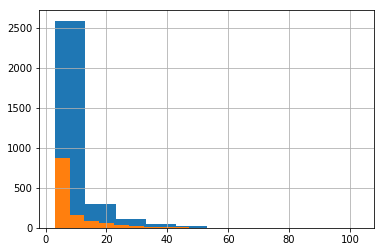

In [239]:
# compare the BIN counts with the block counts. As expected, there are
# more complaints for block than BIN.

df.plumbing_complaints_cat_A_block[df.plumbing_complaints_cat_A_block>2].hist()
df.plumbing_complaints_cat_A[df.plumbing_complaints_cat_A>2].hist()

## 4. Add PLUTO-derived features
 - Building age
 - Years since major alteration

#### 4.1 Building age range

In [ ]:
df.YearBuilt.replace((0,np.nan),inplace=True)

In [319]:
def building_age_range(year):
    if year < 1900:
        return ("pre-1900")
    elif year < 1915:
        return ("1900-1915")
    elif year < 1937:
        return ('1915-1937')
    elif year < 1968:
        return ('1937-1968')
    elif year < 2007:
        return ('1968-2007')
    else:
        return ('2008-2016')

In [320]:
df['building_age'] = df.YearBuilt.apply(building_age_range)

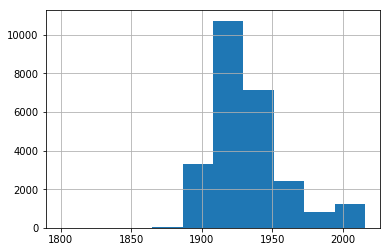

In [324]:
df.YearBuilt.hist()

In [321]:
df.building_age.value_counts(normalize=True)

1915-1937    0.489695
1900-1915    0.216830
1937-1968    0.172422
1968-2007    0.074662
pre-1900     0.028193
2008-2016    0.018199
Name: building_age, dtype: float64

In [325]:
# Add dummies for building age

a=pd.get_dummies(df.building_age)
a.columns=[['pre-1900','1900-1915', '1916-1937', '1938-1967', '1968-2007', '2008-2016']]
df = pd.concat([df,a],axis=1)

#### 4.2 Years since major alteration

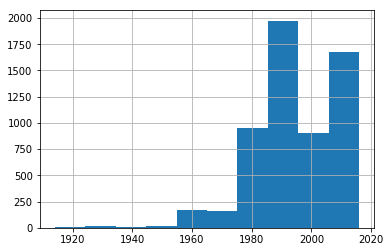

In [276]:
df.YearAlter1.replace(0,np.nan, inplace=True)
df.YearAlter1.hist()

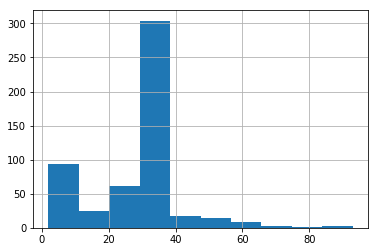

In [288]:
df['years_since_alteration'] = datetime.now().year - df.YearAlter1

df.years_since_alteration[:1000].hist()

In [374]:
## Add function to fill NaNs based on average for the building class
# --> Hongkai, Ozgur?

## 5. Review the set of features for machine learning
How many NaNs do we have? How many unique values?

In [373]:
feature_stats = pd.DataFrame({"NaNs":df.isnull().sum(),"unique":df.nunique()})
feature_stats['percent Nans'] = feature_stats.NaNs / len(df) * 100
feature_stats['percent unique'] = feature_stats.unique / len(df) * 100
feature_stats

,NaNs,unique,percent Nans,percent unique
Unnamed: 0,0,25716,0.000000,100.000000
Unnamed: 0.1,0,25716,0.000000,100.000000
priority_code,0,4,0.000000,0.015555
community_board,0,65,0.000000,0.252761
address,1,19414,0.003889,75.493856
ZIP,17,185,0.066107,0.719396
borough,0,5,0.000000,0.019443
BIN,0,18630,0.000000,72.445170
ID,0,25716,0.000000,100.000000
complaint_category,0,4,0.000000,0.015555
